In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split


## load data

In [2]:
def load_data(df_file):
    df = pd.read_csv(df_file)
    
    return df


## Model training

In [3]:
def KD_model_training(df, leaf_size):
    tree = KDTree(df, leaf_size=leaf_size)

    return tree

## Computing the Top Recommendations

In [4]:
def get_top_recommendations(row, **kwargs) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = None
    data = None
    leaf_size = None
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)
    for key, value in kwargs.items():
        if key == 'k':
            k = value
        elif key == 'data':
            data = value
        elif key == 'leaf_size':
            leaf_size = value
        elif key == 'row_id':
            row_id = value

    tree = KD_model_training(data, leaf_size)

    
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
    dist, idx = tree.query(row, k=k+1)
    
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    idx = idx[0].tolist()
    if row_id in idx:
        idx.remove(row_id)
    else: 
        idx.pop()
    df_result = data.iloc[idx]
    
    # Return the dataset with the k recommendations
    return df_result


## Testing the Recommendation Engine

This will be the main part of your notebook to allow for testing your solutions. Most basically, for a given listing (defined by the row id in your input dataframe), we would like to see the recommendations you make. So however you set up your notebook, it should have at least a comparable section that will allow us to run your solution for different inputs.

### Pick a Sample Listing as Input

In [5]:
# load data
df_train_file = 'processed_data/processed_recommendation_engine_train'
df_test_file = 'processed_data/processed_recommendation_engine_test'

train_cols = ['tenure', 'built_year','num_beds', 'num_baths', 'subzone_property_type_encoding', 'size_sqft', 'price']
out_cols = ['listing_id', 'title', 'address', 'property_name', 'property_details_url', 'lat', 'lng', 'elevation', 'floor_level', 'furnishing', 'available_unit_types']

df_train = load_data(df_train_file)
df_test = load_data(df_test_file)
train_test_delimeter = len(df_train)
df = pd.concat([df_train, df_test])



In [6]:
# standardize data
standard_scalar = preprocessing.StandardScaler()
df_standard = pd.DataFrame(standard_scalar.fit_transform(df[train_cols]), index=df[train_cols].index,columns=train_cols)


In [7]:
# Pick a row id of choice to make recommendation
# row_id = 10
#row_id = 20
#row_id = 30
row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row = df_standard.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
row = pd.DataFrame([row])
row

,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price
40,-0.727269,0.280925,-0.081002,-0.433168,-1.216084,-0.38529,-0.384616


## Compute and Display the recommendations

Since the method `get_top_recommendations()` returns a `pd.DataFrame`, it's easy to display the result.

In [8]:
k = 3
leaf_size = 5

df_recommendations = get_top_recommendations(row, k=k, data=df_standard, leaf_size=leaf_size, row_id=row_id)

# df_recommendations.head(k)

# recommendation output
df[out_cols].iloc[df_recommendations.index.tolist()]


,listing_id,title,address,property_name,property_details_url,lat,lng,elevation,floor_level,furnishing,available_unit_types
14257,794589,hdb flat for sale in 456 segar road,bukit batok / bukit panjang / choa chu kang (d23),segar meadows,https://www.99.co/singapore/hdb/segar-meadows-...,1.387053,103.772288,0,NaN,unspecified,"1, 3, 4 br"
7404,745508,hdb flat for sale in 456 segar road,bukit batok / bukit panjang / choa chu kang (d23),segar meadows,https://www.99.co/singapore/hdb/segar-meadows-...,1.387053,103.772288,0,NaN,unspecified,"1, 3, 4 br"
10918,447266,hdb flat for sale in 442b fajar road,bukit batok / bukit panjang / choa chu kang (d23),fajar hills,https://www.99.co/singapore/hdb/fajar-hills-de...,1.381491,103.771356,0,NaN,unspecified,"2, 3, 4, 5 br"


## Ranking model
* After constructing the above model to make recommendations, we use the distance to decide the order of the recommended properties and this is reasonable. But when we look further into the prediction data, we found that some predictions has same standardized feature values in each attribute and we may not efficiently order the results. 
* So in this part, we want to try a new method called `LGBMRanker` to predict the order of the recommendation. As this method is a regression method, we need to make a assumption that we already have an optimization target. In this task, we set `rank` as our target and get ranking data from KB tree with some randomness (rank with predicted ranking value and if two properties have same values, randomly rank them).
* In the following steps, we constructed a ranking model to predict the listing order of the recommended results, which is based on above assumption and ranking data from KB tree.

### collect recommended properties and rank data for each listing_id with above model
* collect 6 recommended property ranks for each property and let the model learn from these 6 ranks to make recommendations with rank

In [9]:
k = 6
df_rank = pd.DataFrame()

for i in range(len(df)):
    row = df_standard.iloc[i]
    row = pd.DataFrame([row])
    row_recommendations = get_top_recommendations(row, k=k, data=df_standard, leaf_size=leaf_size, row_id=i)

    row_rank = df[out_cols+train_cols].iloc[row_recommendations.index.tolist()]
    row_rank['query_listing_id'] = i
    
    row_rank = row_rank.reset_index().reset_index()
    row_rank.rename(columns={'level_0': 'rank', 'index':'rec_index'},inplace=True)
    
    df_rank = pd.concat([df_rank,row_rank])
    

In [14]:
cols = ['query_listing_id', 'rank', 'rec_index']+out_cols+train_cols
df_rank = df_rank[cols].reset_index()
df_rank = df_rank.drop(['index'],axis=1)
df_rank.head(10)


,query_listing_id,rank,rec_index,listing_id,title,address,property_name,property_details_url,lat,lng,...,floor_level,furnishing,available_unit_types,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price
0,0,0,2492,728625,hdb flat for sale in 873 yishun street 81,sembawang / yishun (d27),873 yishun street 81,https://www.99.co/singapore/hdb/873-yishun-str...,1.414486,103.836871,...,NaN,unspecified,NaN,0.0,1.0,3.0,2.0,568.125814,1119.0,509200.0
1,0,1,234,734954,hdb flat for sale in 609 yishun street 61,sembawang / yishun (d27),nee soon central meadows,https://www.99.co/singapore/hdb/nee-soon-centr...,1.420939,103.836109,...,NaN,unspecified,"3, 4, 5 br",0.0,1.0,3.0,2.0,568.125814,1119.0,522900.0
2,0,2,3330,633561,hdb flat for sale in 817 yishun street 81,sembawang / yishun (d27),817 yishun street 81,https://www.99.co/singapore/hdb/817-yishun-str...,1.413534,103.836625,...,NaN,unspecified,NaN,0.0,1.0,3.0,2.0,568.125814,1119.0,524000.0
3,0,3,17279,515933,hdb flat for sale in 817 yishun street 81,sembawang / yishun (d27),817 yishun street 81,https://www.99.co/singapore/hdb/817-yishun-str...,1.413534,103.836625,...,NaN,unspecified,NaN,0.0,1.0,3.0,2.0,568.125814,1119.0,524000.0
4,0,4,1357,704216,hdb flat for sale in 863 yishun avenue 4,sembawang / yishun (d27),863 yishun avenue 4,https://www.99.co/singapore/hdb/863-yishun-ave...,1.418044,103.840560,...,NaN,unspecified,NaN,0.0,1.0,3.0,2.0,568.125814,1119.0,525000.0
5,0,5,261,836236,hdb flat for sale in 858 yishun avenue 4,sembawang / yishun (d27),858 yishun avenue 4,https://www.99.co/singapore/hdb/858-yishun-ave...,1.418044,103.840560,...,NaN,unspecified,NaN,0.0,1.0,3.0,2.0,568.125814,1119.0,525000.0
6,1,0,2875,688852,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,...,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",0.0,2.0,4.0,2.0,609.170390,1575.0,995400.0
7,1,1,13684,724941,hdb flat for sale in 582 pasir ris street 53,pasir ris / tampines (d18),hdb-pasir ris,https://www.99.co/singapore/hdb/hdbpasir-ris-d...,1.375216,103.946790,...,NaN,unspecified,"studio, 1, 2, 3, 4, 5, 6 br",0.0,2.0,4.0,2.0,611.105631,1582.0,966000.0
8,1,2,1854,871084,hdb flat for sale in 582 pasir ris street 53,pasir ris / tampines (d18),hdb-pasir ris,https://www.99.co/singapore/hdb/hdbpasir-ris-d...,1.375216,103.946790,...,high,partial,"studio, 1, 2, 3, 4, 5, 6 br",0.0,2.0,4.0,2.0,611.105631,1582.0,966000.0
9,1,3,14371,508872,hdb flat for sale in 500 pasir ris street 52,pasir ris / tampines (d18),elias parks estate,https://www.99.co/singapore/hdb/elias-parks-es...,1.375983,103.945966,...,NaN,unspecified,"3, 4 br",0.0,2.0,4.0,2.0,611.105631,1600.0,975300.0


In [15]:
df_rec_train = df_rank[:train_test_delimeter*k]
df_rec_test = df_rank[train_test_delimeter*k:]


#### split train data and evaluation data

In [16]:
col_y = 'rank'

X_train, X_val = train_test_split(df_rec_train, test_size=0.2, random_state=12)
query_train = X_train.groupby("query_listing_id")["query_listing_id"].count().to_numpy()
query_val = X_val.groupby("query_listing_id")["query_listing_id"].count().to_numpy()

y_train = X_train[col_y]
X_train = X_train[train_cols]

y_val = X_val[col_y]
X_val = X_val[train_cols]


### train ranking model with train data
* The features we use to train model are same as what we used for KB tree.
* 20% data is split from training data to make model evalution.

In [17]:
max_label = df_rank['query_listing_id'].nunique()

gbm = lgb.LGBMRanker(label_gain=np.arange(1, max_label+1))
gbm.fit(X_train, y_train, group=query_train,
        eval_set=[(X_val, y_val)], eval_group=[query_val],
        eval_at=10, early_stopping_rounds=100)


[1]	valid_0's ndcg@10: 0.967093
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@10: 0.967381
[3]	valid_0's ndcg@10: 0.967287
[4]	valid_0's ndcg@10: 0.967006
[5]	valid_0's ndcg@10: 0.967103
[6]	valid_0's ndcg@10: 0.967169
[7]	valid_0's ndcg@10: 0.967306
[8]	valid_0's ndcg@10: 0.967388
[9]	valid_0's ndcg@10: 0.967207
[10]	valid_0's ndcg@10: 0.967312
[11]	valid_0's ndcg@10: 0.967651
[12]	valid_0's ndcg@10: 0.967588
[13]	valid_0's ndcg@10: 0.967579
[14]	valid_0's ndcg@10: 0.967311
[15]	valid_0's ndcg@10: 0.9674
[16]	valid_0's ndcg@10: 0.96752
[17]	valid_0's ndcg@10: 0.967479
[18]	valid_0's ndcg@10: 0.967515
[19]	valid_0's ndcg@10: 0.967702
[20]	valid_0's ndcg@10: 0.967613
[21]	valid_0's ndcg@10: 0.967768
[22]	valid_0's ndcg@10: 0.967829
[23]	valid_0's ndcg@10: 0.96778
[24]	valid_0's ndcg@10: 0.967827
[25]	valid_0's ndcg@10: 0.968028
[26]	valid_0's ndcg@10: 0.968024
[27]	valid_0's ndcg@10: 0.968115
[28]	valid_0's ndcg@10: 0.968061
[29]	valid_0's ndcg@10: 0.9

LGBMRanker(label_gain=array([    1,     2,     3, ..., 27117, 27118, 27119]))

### make prediction for listing_id with test data

In [18]:
df_rec_test = pd.DataFrame(df_rec_test)
df_rec_test["predicted_ranking"] = gbm.predict(df_rec_test[train_cols])
df_rec_test['predict_rank'] = df_rec_test.groupby('query_listing_id')['predicted_ranking'].rank(ascending=False)
df_rec_test


,query_listing_id,rank,rec_index,listing_id,title,address,property_name,property_details_url,lat,lng,...,available_unit_types,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price,predicted_ranking,predict_rank
120918,20153,0,930,837946,hdb flat for sale in 504 choa chu kang street 51,bukit batok / bukit panjang / choa chu kang (d23),504 choa chu kang street 51,https://www.99.co/singapore/hdb/504-choa-chu-k...,1.389801,103.743069,...,NaN,0.0,2.0,3.0,2.0,501.068612,1259.0,504000.0,-0.174994,6.0
120919,20153,1,1203,329028,4 bed condo for sale in marina collection,17 cove drive,marina collection,https://www.99.co/singapore/condos-apartments/...,1.243629,103.839247,...,"3, 4, 5, 6 br",0.0,4.0,4.0,6.0,2145.933578,3272.0,6252800.0,-0.098470,3.0
120920,20153,2,2453,360787,hdb flat for sale in 208b clementi avenue 6,buona vista / west coast / clementi (d5),208b clementi avenue 6,https://www.99.co/singapore/hdb/208b-clementi-...,1.321997,103.764085,...,NaN,0.0,4.0,3.0,2.0,755.328227,1001.0,858900.0,0.028099,2.0
120921,20153,3,749,785137,2 bed condo for sale in juniper hill,39 ewe boon road,juniper hill,https://www.99.co/singapore/condos-apartments/...,1.316559,103.829893,...,"1, 2, 3, 4, 5 br",2.0,5.0,2.0,1.0,3235.296974,635.0,1837500.0,-0.149513,5.0
120922,20153,4,952,323476,5 bed house for sale in yio chu kang terrace,yio chu kang terrace,yio chu kang terrace,https://www.99.co/singapore/houses/yio-chu-kan...,1.359024,103.875359,...,"4, 5, 6 br",2.0,1.0,5.0,7.0,1048.425207,6000.0,5544000.0,0.211371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162709,27118,1,4594,905660,2 bed condo for sale in bartley vue,6 jalan bunga rampai,bartley vue,https://www.99.co/singapore/condos-apartments/...,1.340464,103.883733,...,"studio, 1, 2, 3, 4, 5 br",0.0,5.0,2.0,1.0,1940.396647,657.0,1462600.0,0.013705,3.0
162710,27118,2,1524,756489,6 bed house for sale in the carrara,mountbatten road,the carrara,https://www.99.co/singapore/houses/the-carrara...,1.300620,103.892783,...,"studio, 4, 5, 6, 7 br",2.0,5.0,6.0,6.0,1660.562557,6353.0,9825900.0,0.063848,2.0
162711,27118,3,4475,593912,hdb flat for sale in 801 yishun ring road,sembawang / yishun (d27),khatib gardens,https://www.99.co/singapore/hdb/khatib-gardens...,1.424190,103.844932,...,"2, 3 br",0.0,1.0,2.0,2.0,551.465650,635.0,409500.0,0.096959,1.0
162712,27118,4,2773,360377,hdb flat for sale in 211c compassvale lane,hougang / punggol / sengkang (d19),compassvale beacon,https://www.99.co/singapore/hdb/compassvale-be...,1.385263,103.899190,...,3 br,0.0,4.0,3.0,2.0,565.678334,1044.0,588000.0,-0.162509,6.0


#### recommend top 3 properties for each property

In [20]:
predict_recommendation = df_rec_test[df_rec_test['predict_rank']<=3]
predict_recommendation


,query_listing_id,rank,rec_index,listing_id,title,address,property_name,property_details_url,lat,lng,...,available_unit_types,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price,predicted_ranking,predict_rank
120919,20153,1,1203,329028,4 bed condo for sale in marina collection,17 cove drive,marina collection,https://www.99.co/singapore/condos-apartments/...,1.243629,103.839247,...,"3, 4, 5, 6 br",0.0,4.0,4.0,6.0,2145.933578,3272.0,6252800.0,-0.098470,3.0
120920,20153,2,2453,360787,hdb flat for sale in 208b clementi avenue 6,buona vista / west coast / clementi (d5),208b clementi avenue 6,https://www.99.co/singapore/hdb/208b-clementi-...,1.321997,103.764085,...,NaN,0.0,4.0,3.0,2.0,755.328227,1001.0,858900.0,0.028099,2.0
120922,20153,4,952,323476,5 bed house for sale in yio chu kang terrace,yio chu kang terrace,yio chu kang terrace,https://www.99.co/singapore/houses/yio-chu-kan...,1.359024,103.875359,...,"4, 5, 6 br",2.0,1.0,5.0,7.0,1048.425207,6000.0,5544000.0,0.211371,1.0
120924,20154,0,4717,518178,4 bed condo for sale in sky [email protected],1 bedok central,sky [email protected],https://www.99.co/singapore/condos-apartments/...,1.325277,103.932631,...,"1, 2, 3, 4 br",0.0,5.0,4.0,4.0,1972.710810,1302.0,2734200.0,-0.042730,3.0
120926,20154,2,1586,344394,hdb flat for sale in 296 punggol central,hougang / punggol / sengkang (d19),punggol grove,https://www.99.co/singapore/hdb/punggol-grove-...,1.408508,103.891989,...,"studio, 3 br",0.0,3.0,3.0,2.0,562.159079,980.0,556500.0,-0.010891,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162703,27117,1,3447,211412,hdb flat for sale in 417a fernvale link,seletar / yio chu kang (d28),fernvale riverwalk,https://www.99.co/singapore/hdb/fernvale-river...,1.391610,103.880528,...,"1, 2, 3, 4 br",0.0,4.0,3.0,2.0,644.004836,1011.0,672000.0,-0.020503,1.0
162707,27117,5,5917,368962,hdb flat for sale in 477 jurong west street 41,boon lay / jurong / tuas (d22),jurongville @ street 41,https://www.99.co/singapore/hdb/jurongville-st...,1.347687,103.725119,...,"2, 3 br",0.0,1.0,2.0,2.0,487.284506,767.0,404200.0,-0.036352,2.0
162709,27118,1,4594,905660,2 bed condo for sale in bartley vue,6 jalan bunga rampai,bartley vue,https://www.99.co/singapore/condos-apartments/...,1.340464,103.883733,...,"studio, 1, 2, 3, 4, 5 br",0.0,5.0,2.0,1.0,1940.396647,657.0,1462600.0,0.013705,3.0
162710,27118,2,1524,756489,6 bed house for sale in the carrara,mountbatten road,the carrara,https://www.99.co/singapore/houses/the-carrara...,1.300620,103.892783,...,"studio, 4, 5, 6, 7 br",2.0,5.0,6.0,6.0,1660.562557,6353.0,9825900.0,0.063848,2.0


### feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

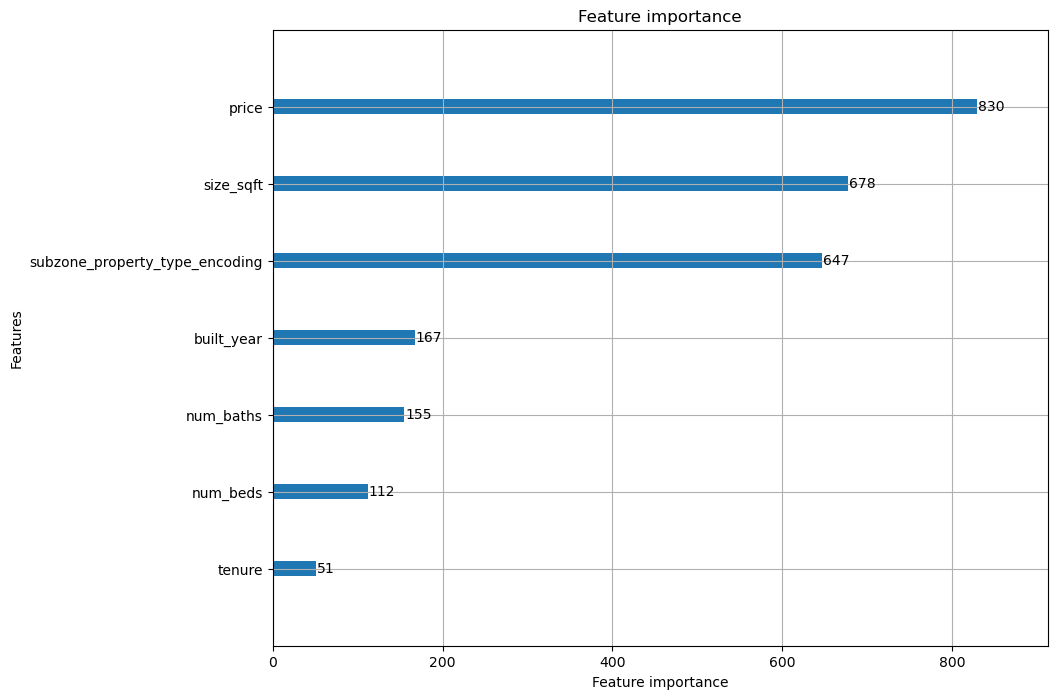

In [19]:
lgb.plot_importance(gbm, figsize = (10,8))